<a href="https://colab.research.google.com/github/irxjxv/DataMining_Assessment/blob/main/Twitter_Depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The goal of this project is to detect depression by using tweets. The training dataset comes from Twitter, gathered using Twint API. The testing dataset is from Kaggle, which is a collection of random tweets containing sentiment scores.

The training dataset will be cleaned and preprocessed for exploratory data analysis and to build a model from it to use for our testing dataset.

In [4]:
# install Twint for scraping data from Twitter

import os

!pip install twint
!pip uninstall twint -y
!git clone --depth=1 https://github.com/twintproject/twint.git
%cd twint/
!pip3 install . -r requirements.txt
!pip install neattext

import twint
import pandas as pd
import nest_asyncio
nest_asyncio.apply()
import time 
import datetime as dt
from glob import glob
import neattext.functions as neat_text
import string


  Using cached twint-2.1.20-py3-none-any.whl


Found existing installation: twint 2.1.20
Uninstalling twint-2.1.20:
  Successfully uninstalled twint-2.1.20
Cloning into 'twint'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 3), reused 14 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.
/content/twint/twint/twint
Processing /content/twint/twint/twint
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for twint: filename=twint-2.1.21-py3-none-any.whl size=38871 sha256=9dc882b5ade8de5df63d2c2f119d8b8c50524eb1bf299561438c04aed1795635
  Stored in directory

In [ ]:
#  creating a function to collect tweets using Twint

def twint_search(search_term, since, until, save_path):
    c = twint.Config()
    c.Search = search_term
    c.Lang = "en"
    c.Since = since.strftime('%Y-%m-%d %H:%M:%S')
    c.Until = until.strftime('%Y-%m-%d %H:%M:%S')
    c.Hide_output = True
    c.Store_csv = True
    c.Output = save_path
    twint.run.Search(c)
    
def twint_search_loop(search_term, start_date, end_date, save_dir):
    try:
        os.makedirs(os.path.join(os.getcwd(),save_dir,search_term))
        print(f'Successfully created the directory {os.path.join(os.getcwd(),save_dir,search_term)}')
    except FileExistsError:
        print(f'Directory {os.path.join(os.getcwd(),save_dir,search_term)} already exists')
    
    date_range = pd.date_range(start_date, end_date)
    
    for single_date in date_range:
        since = single_date
        until = single_date + dt.timedelta(days=1)
        save_path = os.path.join(save_dir, search_term, f'{single_date:%Y%m%d}.csv')
        print(f"Searching for tweets containing '{search_term}' from {single_date:%Y-%m-%d} and saving into {save_path}")
        twint_search(search_term, since, until, save_path)

In [ ]:
# collect tweets with keywords such as depressed, suicide, etc. 
# tweets are gathered from 2022-2008 to achieve 100k data and saved to gdrive, creating a folder for each day with those tweets.

search_term = "depressed OR kill me OR suicide OR want to die OR lonely OR antidepressant OR hopeless OR sadness OR death OR worthless"
start_date = dt.datetime(2008, 1, 1)
end_date = dt.datetime(2022, 2, 13)
save_dir = 'drive/MyDrive/data/'

# run search
twint_search_loop(search_term, start_date, end_date, save_dir)



In [5]:
import os
os.chdir("/content/drive/My Drive/data/depressed OR kill me OR suicide OR want to die OR lonely OR antidepressant OR hopeless OR sadness OR death OR worthless/")
!ls
!pwd

20080102.csv  20101031.csv  20130508.csv  20160303.csv	20190112.csv
20080105.csv  20101101.csv  20130510.csv  20160305.csv	20190113.csv
20080106.csv  20101103.csv  20130511.csv  20160308.csv	20190114.csv
20080123.csv  20101105.csv  20130512.csv  20160309.csv	20190116.csv
20080131.csv  20101106.csv  20130513.csv  20160310.csv	20190117.csv
20080203.csv  20101110.csv  20130514.csv  20160311.csv	20190118.csv
20080207.csv  20101114.csv  20130516.csv  20160312.csv	20190119.csv
20080209.csv  20101117.csv  20130517.csv  20160313.csv	20190120.csv
20080216.csv  20101118.csv  20130519.csv  20160314.csv	20190123.csv
20080220.csv  20101120.csv  20130520.csv  20160315.csv	20190124.csv
20080222.csv  20101127.csv  20130522.csv  20160316.csv	20190127.csv
20080223.csv  20101129.csv  20130526.csv  20160317.csv	20190128.csv
20080229.csv  20101206.csv  20130527.csv  20160324.csv	20190131.csv
20080315.csv  20101208.csv  20130528.csv  20160325.csv	20190201.csv
20080318.csv  20101209.csv  20130531.csv  201603

In [6]:
# get the location of where the tweets are stored and combine them together in 1 file
from glob import glob
import os
import pandas as pd

extension = 'csv'
all_filenames = [i for i in glob('*.{}'.format(extension))]


#combine all files in the list
tweets_df = pd.concat([pd.read_csv(f) for f in all_filenames]).reset_index(drop=True)

tweets_df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,438460348073795584,438460348073795584,2014-02-25 23:47:47 UTC,2014-02-25,23:47:47,0,2330548485,legendarysora,Sora {ソーラ},NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,438459161240539136,438459161240539136,2014-02-25 23:43:04 UTC,2014-02-25,23:43:04,0,2324416650,comenfademe,saved,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,438458283452428289,438458283452428289,2014-02-25 23:39:35 UTC,2014-02-25,23:39:35,0,75959049,jayherrod,Jay Herrod,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,438458006800330752,438457258285228032,2014-02-25 23:38:29 UTC,2014-02-25,23:38:29,0,1042281722,shongo_jr,Engr. Muhammad,"{'type': 'Point', 'coordinates': [2.81962229, ...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,438455764886097920,438453506392195072,2014-02-25 23:29:35 UTC,2014-02-25,23:29:35,0,1042281722,shongo_jr,Engr. Muhammad,"{'type': 'Point', 'coordinates': [2.81960221, ...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101382,759861573888258050,759861573888258050,2016-07-31 21:21:31 UTC,2016-07-31,21:21:31,0,816277746,always_delena4e,Steph ✨,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
101383,759859411397414912,759859268359102464,2016-07-31 21:12:55 UTC,2016-07-31,21:12:55,0,2732905507,simplyzariyah,Zari Murray,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'BruhItsZach', 'name': 'read ...",NaN,NaN,NaN,NaN
101384,759855097786478592,759854700573388800,2016-07-31 20:55:47 UTC,2016-07-31,20:55:47,0,2855488696,mirelezsonofman,GREAT👑PRINCE🔥,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
101385,759853846457831424,759853846457831424,2016-07-31 20:50:49 UTC,2016-07-31,20:50:49,0,2948870993,aishumaj,aish⁷,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN




**The CSV file contains 101387 rows and 36 columns**



In [ ]:
tweets_df.shape

(101387, 36)

In [ ]:
# These are the columns

for col in tweets_df.columns:
    print(col)

id
conversation_id
created_at
date
time
timezone
user_id
username
name
place
tweet
language
mentions
urls
photos
replies_count
retweets_count
likes_count
hashtags
cashtags
link
retweet
quote_url
video
thumbnail
near
geo
source
user_rt_id
user_rt
retweet_id
reply_to
retweet_date
translate
trans_src
trans_dest


**First pre-processing step would be to remove unncessary column names**

In [ ]:
tweets_df.drop(['conversation_id',
          'created_at',
          'timezone',
          'user_id',
          'username',
          'name',
          'place',
          'language',
          'mentions',
          'urls',
          'photos',
          'replies_count',
          'retweets_count',
          'likes_count',
          'hashtags',
          'cashtags',
          'link',
          'retweet',
          'quote_url',
          'video',
          'thumbnail',
          'near',
          'geo',
          'source',
          'user_rt_id',
          'user_rt',
          'retweet_id',
          'reply_to',
          'retweet_date',
          'translate',
          'trans_src',
          'trans_dest'], 
               axis = 1, inplace = True)

In [ ]:
# remaining columns will be id, date, time and tweet

tweets_df.head()

,id,date,time,tweet
0,565344612,2008-01-05,14:16:49,"A wake with a pancit molo to die for, liver pa..."
1,672630282,2008-02-03,12:09:40,bored to death. KILL ME. NOW!!
2,811270499,2008-05-14,17:19:35,Does anyone else want to find and kill the voi...
3,889704673,2008-08-16,21:31:15,"I want to die, someone kill me now"
4,889597234,2008-08-16,18:30:37,@dietcokehead It's a good DVD for someone who ...


In [ ]:
# check if there are any missing rows

tweets_df.isnull().any().any()  

False

In [ ]:
tweets_df.info(null_counts=True) 
tweets_df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101387 entries, 0 to 101386
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      101387 non-null  int64 
 1   date    101387 non-null  object
 2   time    101387 non-null  object
 3   tweet   101387 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


id        int64
date     object
time     object
tweet    object
dtype: object

**RANDOM tweet dataset taken from: https://www.kaggle.com/ywang311/twitter-sentiment/data?select=Sentiment+Analysis+Dataset+2.csv**


Data preprocessing will also be applied to this testing dataset.

In [ ]:
import os
os.chdir("/content/drive/My Drive/testingData/")
!ls
!pwd

GoogleNews-vectors-negative300.bin.gz  testingData.csv
/content/drive/My Drive/testingData


In [ ]:
# get the location of where the tweets are stored and combine them together in 1 csv file
from glob import glob
import os
import pandas as pd

testing_tweets = pd.read_csv('testingData.csv', on_bad_lines='skip')
testing_tweets

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...
...,...,...,...,...
1578607,1578623,1,Sentiment140,Zzzzzz.... Finally! Night tweeters!
1578608,1578624,1,Sentiment140,"Zzzzzzz, sleep well people"
1578609,1578625,0,Sentiment140,ZzzZzZzzzZ... wait no I have homework.
1578610,1578626,0,Sentiment140,"ZzZzzzZZZZzzz meh, what am I doing up again?"


Cleaning up the data more by removing noise such as: 


*   hashtags
*   @ or userhandles

*   URLs
*   multiple spaces

*   numbers









In [ ]:
import neattext.functions as neat_text
tweets_df['clean_tweet'] = tweets_df['tweet'].apply(neat_text.remove_hashtags)
tweets_df['clean_tweet'] = tweets_df['clean_tweet'].apply(lambda x: neat_text.remove_userhandles(x))
tweets_df['clean_tweet'] = tweets_df['clean_tweet'].apply(neat_text.remove_urls)
tweets_df['clean_tweet'] = tweets_df['clean_tweet'].apply(neat_text.remove_multiple_spaces)


testing_tweets['clean_tweet'] = testing_tweets['SentimentText'].apply(neat_text.remove_hashtags)
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].apply(lambda x: neat_text.remove_userhandles(x))
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].apply(neat_text.remove_urls)
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].apply(neat_text.remove_multiple_spaces)


In [ ]:
testing_tweets

,ItemID,Sentiment,SentimentSource,SentimentText,clean_tweet
0,1,0,Sentiment140,is so sad for my APL frie...,is so sad for my APL friend.............
1,2,0,Sentiment140,I missed the New Moon trail...,I missed the New Moon trailer...
2,3,1,Sentiment140,omg its already 7:30 :O,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...,i think mi bf is cheating on me!!! T_T
...,...,...,...,...,...
1578607,1578623,1,Sentiment140,Zzzzzz.... Finally! Night tweeters!,Zzzzzz.... Finally! Night tweeters!
1578608,1578624,1,Sentiment140,"Zzzzzzz, sleep well people","Zzzzzzz, sleep well people"
1578609,1578625,0,Sentiment140,ZzzZzZzzzZ... wait no I have homework.,ZzzZzZzzzZ... wait no I have homework.
1578610,1578626,0,Sentiment140,"ZzZzzzZZZZzzz meh, what am I doing up again?","ZzZzzzZZZZzzz meh, what am I doing up again?"


Turning texts into lowercase to maintain consistency:

In [ ]:
for columns in tweets_df.columns:
    tweets_df['clean_tweet'] = tweets_df['clean_tweet'].str.lower() 

for columns in testing_tweets.columns:
    testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].str.lower() 

Dropping duplicates after removing noise, we will just keep 1 of the duplicates from clean_tweet column. 90K tweets remain after deleting duplicates


In [ ]:
tweets_df.sort_values("clean_tweet", inplace=True)
unique_tweets_df = tweets_df.drop_duplicates(subset=["clean_tweet"],keep = 'first')
unique_tweets_df


testing_tweets.sort_values("clean_tweet", inplace=True)
testing_tweets = testing_tweets.drop_duplicates(subset=["clean_tweet"],keep = 'first')
testing_tweets

,ItemID,Sentiment,SentimentSource,SentimentText,clean_tweet
247530,247543,1,Sentiment140,@iHeartV_JL,
1316334,1316350,0,Sentiment140,@TiffanyHope !,!
4357,4359,1,Sentiment140,#30secondstomars #30secondstomars #30secondsto...,!
462886,462899,1,Sentiment140,@rmccue ! ! ! ! You'll love it! Can't wait to...,! ! ! ! you'll love it! can't wait to see you...
6701,6704,1,Sentiment140,#followfriday @LaurensVerwijs @Chamin @davidal...,! awesome guys
...,...,...,...,...,...
1509387,1509403,0,Sentiment140,ØªÙˆÙ„ÙŠØ¯ÙŠÙ‡ Ø´ÙˆÙ‡Ø± Ø®Ø§Ù„Ù… ÙƒÙ‡ Ø¯ÙŠØ±Ùˆ...,øªùˆù„ùšø¯ùšù‡ ø´ùˆù‡ø± ø®ø§ù„ù… ùƒù‡ ø¯ùšø±ùˆ...
1105670,1105686,1,Sentiment140,ØªÙ‚Ø±ÛŒØ¨Ø§ Ù‡Ù…Ù‡ Ú†ÛŒ Ø³Ø§Ù„Ù…Ù‡ØŒ Ù‡Ø±Ú†Ù†...,øªù‚ø±ûœø¨ø§ ù‡ù…ù‡ ú†ûœ ø³ø§ù„ù…ù‡øœ ù‡ø±ú†ù†...
1105645,1105661,1,Sentiment140,ØµØ¨Ø§Ø­ Ø§Ù„Ø®ÙŠØ± Ù„Ù„Ø¬Ù…ÙŠØ¹ - That mean...,øµø¨ø§ø­ ø§ù„ø®ùšø± ù„ù„ø¬ù…ùšø¹ - that means ...
1303047,1303063,1,Sentiment140,ÙƒÙˆÙƒØ§ ÙƒÙˆÙ„Ø§ - Ù…ØªØ¹Ø© Ø§Ù„ÙƒÙˆÙ„Ø§ : ...,ùƒùˆùƒø§ ùƒùˆù„ø§ - ù…øªø¹ø© ø§ù„ùƒùˆù„ø§ : ø´...


Removing non-ASCII characters


In [ ]:
tweets_df['clean_tweet'] = tweets_df['clean_tweet'].str.encode("ascii", "ignore").str.decode("ascii")
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].str.encode("ascii", "ignore").str.decode("ascii")

testing_tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ItemID,Sentiment,SentimentSource,SentimentText,clean_tweet
247530,247543,1,Sentiment140,@iHeartV_JL,
1316334,1316350,0,Sentiment140,@TiffanyHope !,!
4357,4359,1,Sentiment140,#30secondstomars #30secondstomars #30secondsto...,!
462886,462899,1,Sentiment140,@rmccue ! ! ! ! You'll love it! Can't wait to...,! ! ! ! you'll love it! can't wait to see you...
6701,6704,1,Sentiment140,#followfriday @LaurensVerwijs @Chamin @davidal...,! awesome guys
...,...,...,...,...,...
1509387,1509403,0,Sentiment140,ØªÙˆÙ„ÙŠØ¯ÙŠÙ‡ Ø´ÙˆÙ‡Ø± Ø®Ø§Ù„Ù… ÙƒÙ‡ Ø¯ÙŠØ±Ùˆ...,? [pic]
1105670,1105686,1,Sentiment140,ØªÙ‚Ø±ÛŒØ¨Ø§ Ù‡Ù…Ù‡ Ú†ÛŒ Ø³Ø§Ù„Ù…Ù‡ØŒ Ù‡Ø±Ú†Ù†...,fresh install .
1105645,1105661,1,Sentiment140,ØµØ¨Ø§Ø­ Ø§Ù„Ø®ÙŠØ± Ù„Ù„Ø¬Ù…ÙŠØ¹ - That mean...,- that means &quot;good morning everyone&qu...
1303047,1303063,1,Sentiment140,ÙƒÙˆÙƒØ§ ÙƒÙˆÙ„Ø§ - Ù…ØªØ¹Ø© Ø§Ù„ÙƒÙˆÙ„Ø§ : ...,- : ? ? author: c..


Need to expand contractions for text standardisation. 

In [ ]:
# a list of contractions and their expanded form

contractions = { 
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}


In [ ]:
# expanding contractions
mapping = {k : v for k, v in contractions.items() }
unique_tweets_df['clean_tweet'] = unique_tweets_df['clean_tweet'].replace(mapping, regex=True)
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].replace(mapping, regex=True)
print(unique_tweets_df)
print(testing_tweets)





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                        id        date      time  \
63683   280071086589231104  2012-12-15  22:05:25   
49786  1063552739160973312  2018-11-16  22:01:47   
43817   953035217039712257  2018-01-15  22:44:36   
18771   101795350565765120  2011-08-11  23:21:17   
92853   588737680323645440  2015-04-16  16:16:15   
...                    ...         ...       ...   
40938   900117904351535104  2017-08-22  22:10:06   
47950  1035301077971820544  2018-08-30  22:59:46   
73853  1254494584819810306  2020-04-26  19:36:31   
84944  1454950380379508738  2021-10-31  23:16:17   
81588  1399135647366066179  2021-05-30  22:48:27   

                                                   tweet  \
63683  #i #hate #myself #and #want #to #die #suicide ...   
49786  @ItsTimiDuhh !! Y'all don't want every girl to...   
43817  @tonykill_ !!! i want to see tony kill live be...   
18771  @libertyflintxx !!! like ever!! I'm scared I'm...   
92853  @trashboatTsukki !!!!!!!!! SHET ARE YOU AIMING...   
...            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Remove emojis since these cannot be analysed

In [ ]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
unique_tweets_df['clean_tweet'] = unique_tweets_df['clean_tweet'].apply(lambda s: deEmojify(s))
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].apply(lambda s: deEmojify(s))

unique_tweets_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id,date,time,tweet,clean_tweet
63683,280071086589231104,2012-12-15,22:05:25,#i #hate #myself #and #want #to #die #suicide ...,
49786,1063552739160973312,2018-11-16,22:01:47,@ItsTimiDuhh !! Y'all don't want every girl to...,!! you all do not want every girl to come to ...
43817,953035217039712257,2018-01-15,22:44:36,@tonykill_ !!! i want to see tony kill live be...,!!! i want to see tony kill live before i die
18771,101795350565765120,2011-08-11,23:21:17,@libertyflintxx !!! like ever!! I'm scared I'm...,!!! like ever!! i am scared i am gonna fall o...
92853,588737680323645440,2015-04-16,16:16:15,@trashboatTsukki !!!!!!!!! SHET ARE YOU AIMING...,!!!!!!!!! shet are you aiming to kill me. bec...
...,...,...,...,...,...
40938,900117904351535104,2017-08-22,22:10:06,🤤🤤 death by asphyxiation .. talk dirty to me R...,death by asphyxiation .. talk dirty to me rt ...
47950,1035301077971820544,2018-08-30,22:59:46,🥀 One of my weaknesses is my lack of a green t...,one of my weaknesses is my lack of a green th...
73853,1254494584819810306,2020-04-26,19:36:31,🥺🥺 I’m too selfish to die for someone I love m...,im too selfish to die for someone i love my l...
84944,1454950380379508738,2021-10-31,23:16:17,🦎♊🐉😈🌞🌚🌏🌍🌎🐕 saying I can make people depressed ...,saying i can make people depressed enough to ...


In [ ]:
import string
unique_tweets_df['clean_tweet'] = unique_tweets_df['clean_tweet'].apply(neat_text.remove_puncts)
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].apply(neat_text.remove_puncts)

# Define the function to remove the punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
# Apply to the DF series
unique_tweets_df['clean_tweet'] = unique_tweets_df['clean_tweet'].apply(remove_punctuations)
unique_tweets_df['clean_tweet'] = unique_tweets_df['clean_tweet'].str.replace('“', '')
unique_tweets_df['clean_tweet'] = unique_tweets_df['clean_tweet'].str.replace('amp', '')


testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].apply(remove_punctuations)
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].str.replace('“', '')
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].str.replace('amp', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Remove missing values in clean_tweets column


In [ ]:
import numpy as np

unique_tweets_df = unique_tweets_df.replace(r'^\s*$', np.nan, regex=True)
testing_tweets = testing_tweets.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
unique_tweets_df.loc[63683]

id                                            280071086589231104
date                                                  2012-12-15
time                                                    22:05:25
tweet          #i #hate #myself #and #want #to #die #suicide ...
clean_tweet                                                  NaN
Name: 63683, dtype: object

In [ ]:
unique_tweets_df.dropna(subset=['clean_tweet'], inplace=True)
testing_tweets.dropna(subset=['clean_tweet'], inplace=True)


In [ ]:
unique_tweets_df

,id,date,time,tweet,clean_tweet
49786,1063552739160973312,2018-11-16,22:01:47,@ItsTimiDuhh !! Y'all don't want every girl to...,you all do not want every girl to come to yo...
43817,953035217039712257,2018-01-15,22:44:36,@tonykill_ !!! i want to see tony kill live be...,i want to see tony kill live before i die
18771,101795350565765120,2011-08-11,23:21:17,@libertyflintxx !!! like ever!! I'm scared I'm...,like ever i am scared i am gonna fall off an...
92853,588737680323645440,2015-04-16,16:16:15,@trashboatTsukki !!!!!!!!! SHET ARE YOU AIMING...,shet are you aiming to kill me because i wil...
70303,399665706871963649,2013-11-10,22:31:44,"#FrasesParaTatuajes "" All I need is Love "" Bor...",all i need is love born to die born to kill...
...,...,...,...,...,...
40938,900117904351535104,2017-08-22,22:10:06,🤤🤤 death by asphyxiation .. talk dirty to me R...,death by asphyxiation talk dirty to me rt ho...
47950,1035301077971820544,2018-08-30,22:59:46,🥀 One of my weaknesses is my lack of a green t...,one of my weaknesses is my lack of a green th...
73853,1254494584819810306,2020-04-26,19:36:31,🥺🥺 I’m too selfish to die for someone I love m...,im too selfish to die for someone i love my l...
84944,1454950380379508738,2021-10-31,23:16:17,🦎♊🐉😈🌞🌚🌏🌍🌎🐕 saying I can make people depressed ...,saying i can make people depressed enough to ...


In [ ]:
testing_tweets

,ItemID,Sentiment,SentimentSource,SentimentText,clean_tweet
462886,462899,1,Sentiment140,@rmccue ! ! ! ! You'll love it! Can't wait to...,you will love it cannot wait to see you a...
6701,6704,1,Sentiment140,#followfriday @LaurensVerwijs @Chamin @davidal...,awesome guys
9735,9748,1,Sentiment140,"#followfriday ! @rjgeyer, @slimburkett, @mckay...",because they make me happy when skys are grey
832562,832578,1,Sentiment140,http://bit.ly/Al9NU ! carolina liar - show ...,carolina liar show me what im looking for
125089,125102,0,Sentiment140,@cgladson ! come to the pub,come to the pub
...,...,...,...,...,...
1509387,1509403,0,Sentiment140,ØªÙˆÙ„ÙŠØ¯ÙŠÙ‡ Ø´ÙˆÙ‡Ø± Ø®Ø§Ù„Ù… ÙƒÙ‡ Ø¯ÙŠØ±Ùˆ...,pic
1105670,1105686,1,Sentiment140,ØªÙ‚Ø±ÛŒØ¨Ø§ Ù‡Ù…Ù‡ Ú†ÛŒ Ø³Ø§Ù„Ù…Ù‡ØŒ Ù‡Ø±Ú†Ù†...,fresh install
1105645,1105661,1,Sentiment140,ØµØ¨Ø§Ø­ Ø§Ù„Ø®ÙŠØ± Ù„Ù„Ø¬Ù…ÙŠØ¹ - That mean...,that means quotgood morning everyonequot
1303047,1303063,1,Sentiment140,ÙƒÙˆÙƒØ§ ÙƒÙˆÙ„Ø§ - Ù…ØªØ¹Ø© Ø§Ù„ÙƒÙˆÙ„Ø§ : ...,author c


Removing stop words

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

unique_tweets_df['clean_tweet'] = unique_tweets_df['clean_tweet'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords])) 
unique_tweets_df
testing_tweets['clean_tweet'] = testing_tweets['clean_tweet'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords])) 
testing_tweets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ItemID,Sentiment,SentimentSource,SentimentText,clean_tweet
462886,462899,1,Sentiment140,@rmccue ! ! ! ! You'll love it! Can't wait to...,love cannot wait see admin best server ever happy
6701,6704,1,Sentiment140,#followfriday @LaurensVerwijs @Chamin @davidal...,awesome guys
9735,9748,1,Sentiment140,"#followfriday ! @rjgeyer, @slimburkett, @mckay...",make happy skys grey
832562,832578,1,Sentiment140,http://bit.ly/Al9NU ! carolina liar - show ...,carolina liar show im looking
125089,125102,0,Sentiment140,@cgladson ! come to the pub,come pub
...,...,...,...,...,...
1509387,1509403,0,Sentiment140,ØªÙˆÙ„ÙŠØ¯ÙŠÙ‡ Ø´ÙˆÙ‡Ø± Ø®Ø§Ù„Ù… ÙƒÙ‡ Ø¯ÙŠØ±Ùˆ...,pic
1105670,1105686,1,Sentiment140,ØªÙ‚Ø±ÛŒØ¨Ø§ Ù‡Ù…Ù‡ Ú†ÛŒ Ø³Ø§Ù„Ù…Ù‡ØŒ Ù‡Ø±Ú†Ù†...,fresh install
1105645,1105661,1,Sentiment140,ØµØ¨Ø§Ø­ Ø§Ù„Ø®ÙŠØ± Ù„Ù„Ø¬Ù…ÙŠØ¹ - That mean...,means quotgood morning everyonequot
1303047,1303063,1,Sentiment140,ÙƒÙˆÙƒØ§ ÙƒÙˆÙ„Ø§ - Ù…ØªØ¹Ø© Ø§Ù„ÙƒÙˆÙ„Ø§ : ...,author c


**Adding Sentiment Analysis using Vader**

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
unique_tweets_df['compound_vader_score'] = unique_tweets_df['clean_tweet'].apply(lambda x: analyser.polarity_scores(x))
unique_tweets_df

,id,date,time,tweet,clean_tweet,compound_vader_score
49786,1063552739160973312,2018-11-16,22:01:47,@ItsTimiDuhh !! Y'all don't want every girl to...,want every girl come woman promise kill die ni...,"{'neg': 0.596, 'neu': 0.16, 'pos': 0.244, 'com..."
43817,953035217039712257,2018-01-15,22:44:36,@tonykill_ !!! i want to see tony kill live be...,want see tony kill live die,"{'neg': 0.667, 'neu': 0.233, 'pos': 0.101, 'co..."
18771,101795350565765120,2011-08-11,23:21:17,@libertyflintxx !!! like ever!! I'm scared I'm...,like ever scared gonna fall sharks come kill d...,"{'neg': 0.575, 'neu': 0.3, 'pos': 0.125, 'comp..."
92853,588737680323645440,2015-04-16,16:16:15,@trashboatTsukki !!!!!!!!! SHET ARE YOU AIMING...,shet aiming kill gladly accept death,"{'neg': 0.551, 'neu': 0.128, 'pos': 0.321, 'co..."
70303,399665706871963649,2013-11-10,22:31:44,"#FrasesParaTatuajes "" All I need is Love "" Bor...",need love born die born kill let go sei l cara...,"{'neg': 0.333, 'neu': 0.388, 'pos': 0.279, 'co..."
...,...,...,...,...,...,...
40938,900117904351535104,2017-08-22,22:10:06,🤤🤤 death by asphyxiation .. talk dirty to me R...,death asphyxiation talk dirty rt honeyyslove i...,"{'neg': 0.741, 'neu': 0.259, 'pos': 0.0, 'comp..."
47950,1035301077971820544,2018-08-30,22:59:46,🥀 One of my weaknesses is my lack of a green t...,one weaknesses lack green thumb literally kill...,"{'neg': 0.383, 'neu': 0.4, 'pos': 0.217, 'comp..."
73853,1254494584819810306,2020-04-26,19:36:31,🥺🥺 I’m too selfish to die for someone I love m...,im selfish die someone love life im sorry woul...,"{'neg': 0.608, 'neu': 0.211, 'pos': 0.181, 'co..."
84944,1454950380379508738,2021-10-31,23:16:17,🦎♊🐉😈🌞🌚🌏🌍🌎🐕 saying I can make people depressed ...,saying make people depressed enough commit sui...,"{'neg': 0.369, 'neu': 0.34, 'pos': 0.291, 'com..."


In [ ]:
def sentimentPredict(sentiment):
  if sentiment['compound'] >= 0.05:
    return "Positive"
  elif sentiment['compound'] <= -0.05: 
    return "Negative"
  else:
    return "Neutral"
unique_tweets_df['sentiment_label'] = unique_tweets_df['compound_vader_score'].apply(lambda x: sentimentPredict(x))
unique_tweets_df.head(10)

,id,date,time,tweet,clean_tweet,compound_vader_score,sentiment_label
49786,1063552739160973312,2018-11-16,22:01:47,@ItsTimiDuhh !! Y'all don't want every girl to...,want every girl come woman promise kill die ni...,"{'neg': 0.596, 'neu': 0.16, 'pos': 0.244, 'com...",Negative
43817,953035217039712257,2018-01-15,22:44:36,@tonykill_ !!! i want to see tony kill live be...,want see tony kill live die,"{'neg': 0.667, 'neu': 0.233, 'pos': 0.101, 'co...",Negative
18771,101795350565765120,2011-08-11,23:21:17,@libertyflintxx !!! like ever!! I'm scared I'm...,like ever scared gonna fall sharks come kill d...,"{'neg': 0.575, 'neu': 0.3, 'pos': 0.125, 'comp...",Negative
92853,588737680323645440,2015-04-16,16:16:15,@trashboatTsukki !!!!!!!!! SHET ARE YOU AIMING...,shet aiming kill gladly accept death,"{'neg': 0.551, 'neu': 0.128, 'pos': 0.321, 'co...",Negative
70303,399665706871963649,2013-11-10,22:31:44,"#FrasesParaTatuajes "" All I need is Love "" Bor...",need love born die born kill let go sei l cara...,"{'neg': 0.333, 'neu': 0.388, 'pos': 0.279, 'co...",Negative
2741,490983585298800640,2014-07-20,22:16:23,"@angelriddle_rpg "" All the death eaters in our...",death eaters world want kill much want never s...,"{'neg': 0.55, 'neu': 0.245, 'pos': 0.206, 'com...",Negative
78874,1345104296539512836,2021-01-01,20:27:09,"@DarkDeityMiku "" as if i am scared of it. We c...",scared cobtrol one hardest energy death bring ...,"{'neg': 0.377, 'neu': 0.35, 'pos': 0.272, 'com...",Negative
95573,639869802409013248,2015-09-04,18:37:03,"#SpookyVibes ""@TygressAndy: Ashes to ashes ""@S...",ashes ashes die flu kill ah,"{'neg': 0.789, 'neu': 0.211, 'pos': 0.0, 'comp...",Negative
95825,645002087982608384,2015-09-18,22:30:55,"@JanieTheKillr "" I don't want you to die.....""...",want die tried kill self three times always fail,"{'neg': 0.658, 'neu': 0.272, 'pos': 0.071, 'co...",Negative
26755,198120970375004160,2012-05-03,18:44:54,"@Shevy21@reenz82@sarikas80 ""@FillWerrell: I ...",keep room messy someone tries kill trip die,"{'neg': 0.689, 'neu': 0.311, 'pos': 0.0, 'comp...",Negative


In [ ]:
unique_tweets_df['sentiment_label'].value_counts()

Negative    83743
Positive     5819
Neutral      1121
Name: sentiment_label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


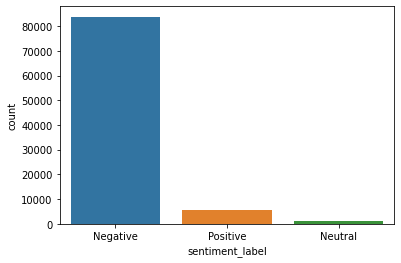

In [ ]:
import seaborn as sns

sns.countplot(unique_tweets_df['sentiment_label'])

**Tokenization**

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

tokenized_tweets = unique_tweets_df.apply(lambda row: nltk.word_tokenize(row['clean_tweet']), axis=1)
tokenized_testing_tweets = testing_tweets.apply(lambda row: nltk.word_tokenize(row['clean_tweet']), axis=1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


KeyboardInterrupt: ignored

Get most common words after splitting the tweets 



In [ ]:
from collections import Counter
import collections
import itertools

all_words = list(itertools.chain(*tokenized_tweets))
Counter = collections.Counter(all_words)
common_words = Counter.most_common(10)
common_words


[('kill', 83483),
 ('die', 60578),
 ('want', 39702),
 ('death', 24117),
 ('would', 11275),
 ('like', 10452),
 ('going', 9861),
 ('depressed', 9441),
 ('people', 8890),
 ('im', 7574)]

In [ ]:
all_words = list(itertools.chain(*tokenized_testing_tweets))
Counter = collections.Counter(all_words)
testing_common_words = Counter.most_common(10)
testing_common_words = pd.DataFrame(testing_common_words, 
                            columns=['words', 'count'])
testing_common_words

,words,count
0,good,85276
1,day,79437
2,get,79421
3,like,76960
4,go,72028
5,got,68875
6,today,63916
7,going,63338
8,love,62517
9,work,60859


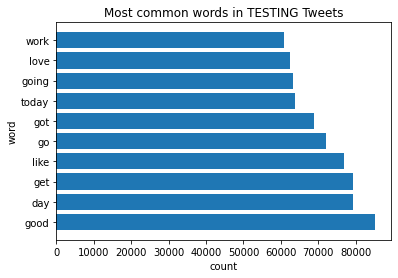

In [ ]:
import matplotlib.pyplot as plt
y_axis = testing_common_words['words']
x_axis = testing_common_words['count']
plt.title('Most common words in TESTING Tweets')
plt.barh(y_axis,x_axis)
plt.ylabel('word')
plt.xlabel('count')
plt.show()

In [ ]:
common_words_in_tweets = pd.DataFrame(common_words, 
                            columns=['words', 'count'])
common_words_in_tweets

,words,count
0,kill,83483
1,die,60578
2,want,39702
3,death,24117
4,would,11275
5,like,10452
6,going,9861
7,depressed,9441
8,people,8890
9,im,7574


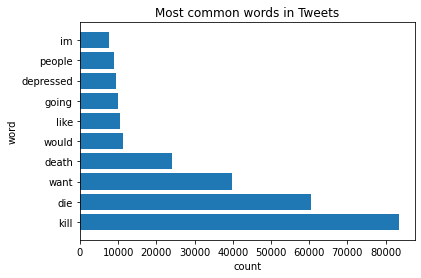

In [ ]:
import matplotlib.pyplot as plt

y_axis = common_words_in_tweets['words']
x_axis = common_words_in_tweets['count']
plt.title('Most common words in Tweets')
plt.barh(y_axis,x_axis)
plt.ylabel('word')
plt.xlabel('count')
plt.show()

Number of Characters - This does not include spaces.

In [ ]:
import re
unique_tweets_df['character_count'] = unique_tweets_df['clean_tweet'].apply(lambda x: len(re.sub(r"\s+", "",x, flags=re.UNICODE)))
testing_tweets['character_count'] = testing_tweets['clean_tweet'].apply(lambda x: len(re.sub(r"\s+", "",x, flags=re.UNICODE)))


,id,date,time,tweet,clean_tweet,compound_vader_score,sentiment_label,character_count
49786,1063552739160973312,2018-11-16,22:01:47,@ItsTimiDuhh !! Y'all don't want every girl to...,want every girl come woman promise kill die ni...,"{'neg': 0.596, 'neu': 0.16, 'pos': 0.244, 'com...",Negative,50
43817,953035217039712257,2018-01-15,22:44:36,@tonykill_ !!! i want to see tony kill live be...,want see tony kill live die,"{'neg': 0.667, 'neu': 0.233, 'pos': 0.101, 'co...",Negative,22
18765,101795350565765120,2011-08-11,23:21:17,@libertyflintxx !!! like ever!! I'm scared I'm...,like ever scared gonna fall sharks come kill d...,"{'neg': 0.575, 'neu': 0.3, 'pos': 0.125, 'comp...",Negative,48
92853,588737680323645440,2015-04-16,16:16:15,@trashboatTsukki !!!!!!!!! SHET ARE YOU AIMING...,shet aiming kill gladly accept death,"{'neg': 0.551, 'neu': 0.128, 'pos': 0.321, 'co...",Negative,31
70303,399665706871963649,2013-11-10,22:31:44,"#FrasesParaTatuajes "" All I need is Love "" Bor...",need love born die born kill let go sei l cara...,"{'neg': 0.333, 'neu': 0.388, 'pos': 0.279, 'co...",Negative,51
...,...,...,...,...,...,...,...,...
40938,900117904351535104,2017-08-22,22:10:06,🤤🤤 death by asphyxiation .. talk dirty to me R...,death asphyxiation talk dirty rt honeyyslove i...,"{'neg': 0.741, 'neu': 0.259, 'pos': 0.0, 'comp...",Negative,51
47950,1035301077971820544,2018-08-30,22:59:46,🥀 One of my weaknesses is my lack of a green t...,one weaknesses lack green thumb literally kill...,"{'neg': 0.383, 'neu': 0.4, 'pos': 0.217, 'comp...",Negative,100
73853,1254494584819810306,2020-04-26,19:36:31,🥺🥺 I’m too selfish to die for someone I love m...,im selfish die someone love life im sorry woul...,"{'neg': 0.608, 'neu': 0.211, 'pos': 0.181, 'co...",Negative,69
84944,1454950380379508738,2021-10-31,23:16:17,🦎♊🐉😈🌞🌚🌏🌍🌎🐕 saying I can make people depressed ...,saying make people depressed enough commit sui...,"{'neg': 0.369, 'neu': 0.34, 'pos': 0.291, 'com...",Negative,140


In [ ]:
unique_tweets_df['character_count'].describe()

count    90683.000000
mean        66.131182
std         35.762517
min          0.000000
25%         41.000000
50%         58.000000
75%         79.000000
max        228.000000
Name: character_count, dtype: float64

Number of words

In [ ]:
unique_tweets_df['word_count'] = unique_tweets_df['clean_tweet'].apply(lambda x: len(str(x).split(" ")))
testing_tweets['word_count'] = testing_tweets['clean_tweet'].apply(lambda x: len(str(x).split(" ")))


,id,date,time,tweet,clean_tweet,compound_vader_score,sentiment_label,character_count,word_count
49786,1063552739160973312,2018-11-16,22:01:47,@ItsTimiDuhh !! Y'all don't want every girl to...,want every girl come woman promise kill die ni...,"{'neg': 0.596, 'neu': 0.16, 'pos': 0.244, 'com...",Negative,50,11
43817,953035217039712257,2018-01-15,22:44:36,@tonykill_ !!! i want to see tony kill live be...,want see tony kill live die,"{'neg': 0.667, 'neu': 0.233, 'pos': 0.101, 'co...",Negative,22,6
18765,101795350565765120,2011-08-11,23:21:17,@libertyflintxx !!! like ever!! I'm scared I'm...,like ever scared gonna fall sharks come kill d...,"{'neg': 0.575, 'neu': 0.3, 'pos': 0.125, 'comp...",Negative,48,10
92853,588737680323645440,2015-04-16,16:16:15,@trashboatTsukki !!!!!!!!! SHET ARE YOU AIMING...,shet aiming kill gladly accept death,"{'neg': 0.551, 'neu': 0.128, 'pos': 0.321, 'co...",Negative,31,6
70303,399665706871963649,2013-11-10,22:31:44,"#FrasesParaTatuajes "" All I need is Love "" Bor...",need love born die born kill let go sei l cara...,"{'neg': 0.333, 'neu': 0.388, 'pos': 0.279, 'co...",Negative,51,14
...,...,...,...,...,...,...,...,...,...
40938,900117904351535104,2017-08-22,22:10:06,🤤🤤 death by asphyxiation .. talk dirty to me R...,death asphyxiation talk dirty rt honeyyslove i...,"{'neg': 0.741, 'neu': 0.259, 'pos': 0.0, 'comp...",Negative,51,9
47950,1035301077971820544,2018-08-30,22:59:46,🥀 One of my weaknesses is my lack of a green t...,one weaknesses lack green thumb literally kill...,"{'neg': 0.383, 'neu': 0.4, 'pos': 0.217, 'comp...",Negative,100,20
73853,1254494584819810306,2020-04-26,19:36:31,🥺🥺 I’m too selfish to die for someone I love m...,im selfish die someone love life im sorry woul...,"{'neg': 0.608, 'neu': 0.211, 'pos': 0.181, 'co...",Negative,69,15
84944,1454950380379508738,2021-10-31,23:16:17,🦎♊🐉😈🌞🌚🌏🌍🌎🐕 saying I can make people depressed ...,saying make people depressed enough commit sui...,"{'neg': 0.369, 'neu': 0.34, 'pos': 0.291, 'com...",Negative,140,27


In [ ]:
unique_tweets_df['word_count'].describe()

count    90683.000000
mean        13.227816
std          6.454735
min          1.000000
25%          9.000000
50%         12.000000
75%         16.000000
max         51.000000
Name: word_count, dtype: float64

**Word Cloud for each positive/negative/neutral to see the difference**

In [ ]:
from wordcloud import WordCloud
def plot_wordcloud(words):
    plt.figure(figsize=(15,10))
    mywordcloud = WordCloud().generate(words)
    plt.imshow(mywordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
positive_tweets = unique_tweets_df[unique_tweets_df['sentiment_label'] == 'Positive']['clean_tweet']
negative_tweets = unique_tweets_df[unique_tweets_df['sentiment_label'] == 'Negative']['clean_tweet']
neutral_tweets = unique_tweets_df[unique_tweets_df['sentiment_label'] == 'Neutral']['clean_tweet']


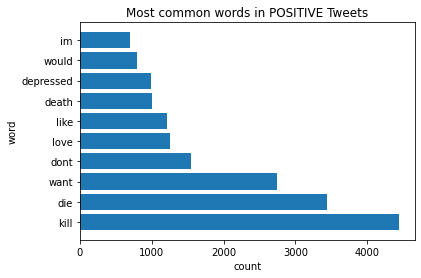

In [ ]:
# for positive tweets

pos_df = positive_tweets.to_frame()
pos_df

pos_tokenized_tweets = pos_df.apply(lambda row: nltk.word_tokenize(row['clean_tweet']), axis=1)
pos_tokenized_tweets

pos_words = list(itertools.chain(*pos_tokenized_tweets))
Counter = collections.Counter(pos_words)
pos_common_words = Counter.most_common(10)

pos_common_words_in_tweets = pd.DataFrame(pos_common_words, 
                            columns=['words', 'count'])
pos_common_words_in_tweets


y_axis = pos_common_words_in_tweets['words']
x_axis = pos_common_words_in_tweets['count']
plt.title('Most common words in POSITIVE Tweets')
plt.barh(y_axis,x_axis)
plt.ylabel('word')
plt.xlabel('count')
plt.show()

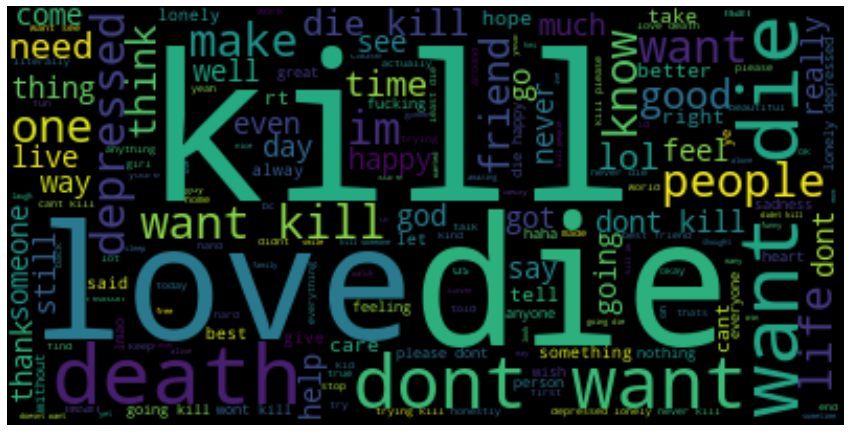

In [ ]:
pos_tokens = [token for line in positive_tweets  for token in line.split()]
pos_docx = ' '.join(pos_tokens)
plot_wordcloud(pos_docx)

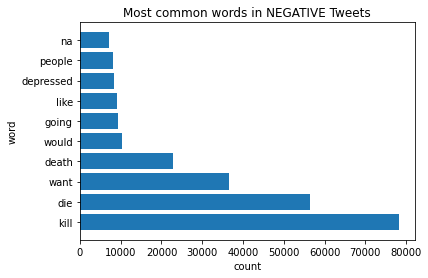

In [ ]:
# for negative tweets
neg_df = negative_tweets.to_frame()
neg_df

neg_tokenized_tweets = neg_df.apply(lambda row: nltk.word_tokenize(row['clean_tweet']), axis=1)
neg_tokenized_tweets

neg_words = list(itertools.chain(*neg_tokenized_tweets))
Counter = collections.Counter(neg_words)
neg_common_words = Counter.most_common(10)

neg_common_words_in_tweets = pd.DataFrame(neg_common_words, 
                            columns=['words', 'count'])
neg_common_words_in_tweets

y_axis = neg_common_words_in_tweets['words']
x_axis = neg_common_words_in_tweets['count']
plt.title('Most common words in NEGATIVE Tweets')
plt.barh(y_axis,x_axis)
plt.ylabel('word')
plt.xlabel('count')
plt.show()

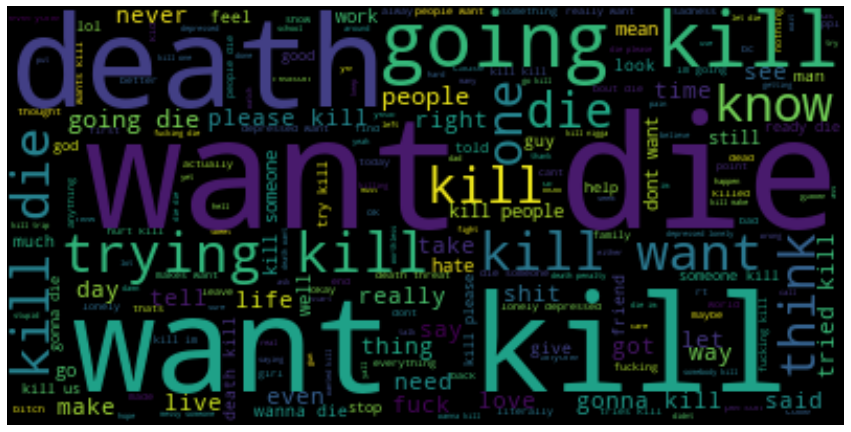

In [ ]:
neg_tokens = [token for line in negative_tweets  for token in line.split()]

neg_docx = ' '.join(neg_tokens)
plot_wordcloud(neg_docx)

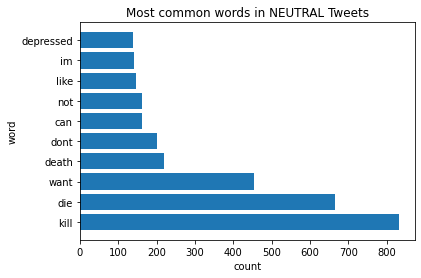

In [ ]:
# for neutral tweets
neu_df = neutral_tweets.to_frame()
neu_df

neu_tokenized_tweets = neu_df.apply(lambda row: nltk.word_tokenize(row['clean_tweet']), axis=1)
neu_tokenized_tweets

neu_words = list(itertools.chain(*neu_tokenized_tweets))
Counter = collections.Counter(neu_words)
neu_common_words = Counter.most_common(10)

neu_common_words_in_tweets = pd.DataFrame(neu_common_words, 
                            columns=['words', 'count'])
neu_common_words_in_tweets

y_axis = neu_common_words_in_tweets['words']
x_axis = neu_common_words_in_tweets['count']
plt.title('Most common words in NEUTRAL Tweets')
plt.barh(y_axis,x_axis)
plt.ylabel('word')
plt.xlabel('count')
plt.show()

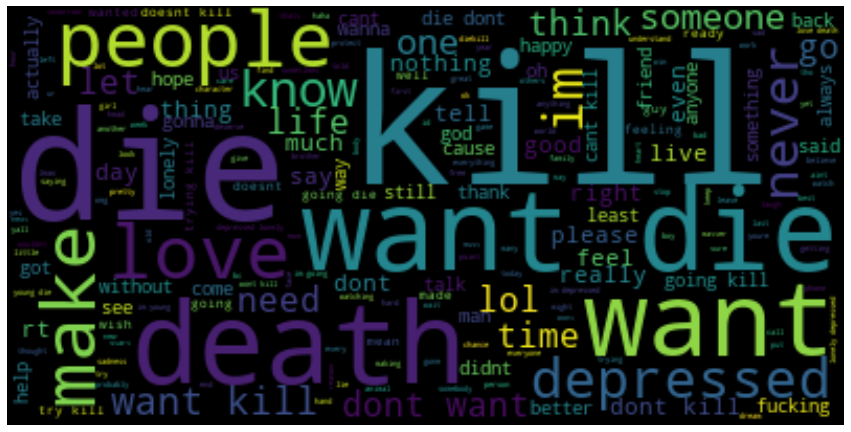

In [ ]:
neu_tokens = [token for line in neutral_tweets  for token in line.split()]

neu_docx = ' '.join(neu_tokens)
plot_wordcloud(neu_docx)

In [ ]:
unique_tweets_df

,id,date,time,tweet,clean_tweet,compound_vader_score,sentiment_label,time_of_tweet
49786,1063552739160973312,2018-11-16,22:01:47,@ItsTimiDuhh !! Y'all don't want every girl to...,want every girl come woman promise kill die ni...,"{'neg': 0.596, 'neu': 0.16, 'pos': 0.244, 'com...",Negative,2018-11-16 22:01:47
43817,953035217039712257,2018-01-15,22:44:36,@tonykill_ !!! i want to see tony kill live be...,want see tony kill live die,"{'neg': 0.667, 'neu': 0.233, 'pos': 0.101, 'co...",Negative,2018-01-15 22:44:36
18765,101795350565765120,2011-08-11,23:21:17,@libertyflintxx !!! like ever!! I'm scared I'm...,like ever scared gonna fall sharks come kill d...,"{'neg': 0.575, 'neu': 0.3, 'pos': 0.125, 'comp...",Negative,2011-08-11 23:21:17
92853,588737680323645440,2015-04-16,16:16:15,@trashboatTsukki !!!!!!!!! SHET ARE YOU AIMING...,shet aiming kill gladly accept death,"{'neg': 0.551, 'neu': 0.128, 'pos': 0.321, 'co...",Negative,2015-04-16 16:16:15
70303,399665706871963649,2013-11-10,22:31:44,"#FrasesParaTatuajes "" All I need is Love "" Bor...",need love born die born kill let go sei l cara...,"{'neg': 0.333, 'neu': 0.388, 'pos': 0.279, 'co...",Negative,2013-11-10 22:31:44
...,...,...,...,...,...,...,...,...
40938,900117904351535104,2017-08-22,22:10:06,🤤🤤 death by asphyxiation .. talk dirty to me R...,death asphyxiation talk dirty rt honeyyslove i...,"{'neg': 0.741, 'neu': 0.259, 'pos': 0.0, 'comp...",Negative,2017-08-22 22:10:06
47950,1035301077971820544,2018-08-30,22:59:46,🥀 One of my weaknesses is my lack of a green t...,one weaknesses lack green thumb literally kill...,"{'neg': 0.383, 'neu': 0.4, 'pos': 0.217, 'comp...",Negative,2018-08-30 22:59:46
73853,1254494584819810306,2020-04-26,19:36:31,🥺🥺 I’m too selfish to die for someone I love m...,im selfish die someone love life im sorry woul...,"{'neg': 0.608, 'neu': 0.211, 'pos': 0.181, 'co...",Negative,2020-04-26 19:36:31
84944,1454950380379508738,2021-10-31,23:16:17,🦎♊🐉😈🌞🌚🌏🌍🌎🐕 saying I can make people depressed ...,saying make people depressed enough commit sui...,"{'neg': 0.369, 'neu': 0.34, 'pos': 0.291, 'com...",Negative,2021-10-31 23:16:17


In [ ]:
unique_tweets_df['time_of_tweet'] = unique_tweets_df['date'] + ' ' + unique_tweets_df['time']
unique_tweets_df
# dfcounts = unique_tweets_df.set_index('time_of_tweet').resample('1H').count()

series = unique_tweets_df.clean_tweet.groupby(pd.to_datetime(unique_tweets_df.time_of_tweet).dt.hour).count()
dfcounts = series.to_frame()
dfcounts


,clean_tweet
time_of_tweet,
0,514
1,554
2,564
3,653
4,680
5,691
6,666
7,579
8,527


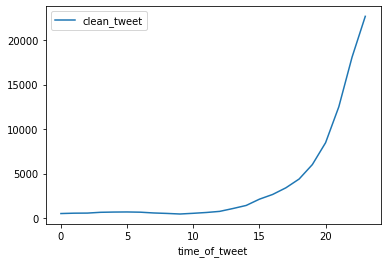

In [ ]:
dfcounts.plot.line()

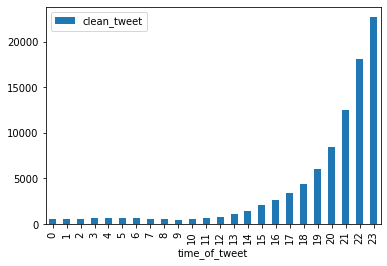

In [ ]:
dfcounts.plot.bar()

**N-GRAMS**

In [ ]:
tokenized_tweets

49786    [want, every, girl, come, woman, promise, kill...
43817                   [want, see, tony, kill, live, die]
18765    [like, ever, scared, gon, na, fall, sharks, co...
92853          [shet, aiming, kill, gladly, accept, death]
70303    [need, love, born, die, born, kill, let, go, s...
                               ...                        
40938    [death, asphyxiation, talk, dirty, rt, honeyys...
47950    [one, weaknesses, lack, green, thumb, literall...
73853    [im, selfish, die, someone, love, life, im, so...
84944    [saying, make, people, depressed, enough, comm...
81588    [stop, sad, sadness, make, even, uglier, reali...
Length: 90683, dtype: object

In [ ]:
# !pip install -U textblob 
# !python -m textblob.download_corpora

from textblob import TextBlob

c=collections.Counter()
for clean_tweet in unique_tweets_df['clean_tweet']:
  x = clean_tweet.rstrip().split(" ")
  c.update(set(zip(x[:-1],x[1:])))

c

Counter({('ready', 'die'): 1115,
         ('girl', 'come'): 1,
         ('woman', 'promise'): 1,
         ('promise', 'kill'): 35,
         ('every', 'girl'): 3,
         ('kill', 'die'): 2748,
         ('want', 'every'): 14,
         ('niggas', 'ready'): 5,
         ('come', 'woman'): 1,
         ('die', 'niggas'): 10,
         ('want', 'see'): 542,
         ('kill', 'live'): 106,
         ('see', 'tony'): 1,
         ('tony', 'kill'): 5,
         ('live', 'die'): 187,
         ('fall', 'sharks'): 1,
         ('sharks', 'come'): 1,
         ('ever', 'scared'): 1,
         ('death', 'naaart'): 1,
         ('come', 'kill'): 453,
         ('gonna', 'fall'): 2,
         ('scared', 'gonna'): 9,
         ('kill', 'death'): 1496,
         ('like', 'ever'): 11,
         ('gladly', 'accept'): 3,
         ('kill', 'gladly'): 10,
         ('shet', 'aiming'): 1,
         ('accept', 'death'): 38,
         ('aiming', 'kill'): 4,
         ('l', 'cara'): 1,
         ('sem', 'inspirao'): 1,
         (

In [ ]:
df = pd.DataFrame.from_dict(c, orient='index').reset_index()
df = df.rename(columns={'index':'bigrams', 0:'count'})
df.sort_values('count', ascending=False)

,bigrams,count
79,"(want, die)",13453
44,"(want, kill)",9483
171,"(going, kill)",4018
122,"(trying, kill)",3796
274,"(die, kill)",3442
...,...,...
215148,"(watch, everything)",1
215146,"(sulking, lonely)",1
215144,"(performance, imo)",1
215143,"(imo, call)",1


Tokenizing to get only the top 20000 most frequent words using Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
np.random.seed(1234)

TRAIN_NROWS = 15000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
TEST_NROWS = 10000


# train_df = unique_tweets_df.sample(n=TRAIN_NROWS)
# test_df = testing_tweets.sample(n=TEST_NROWS)

train_df = unique_tweets_df.head(TRAIN_NROWS)
test_df = testing_tweets.head(TEST_NROWS)


In [ ]:
depressive_tweets = [x for x in train_df['clean_tweet']]
random_tweets = [x for x in test_df['clean_tweet']]

In [ ]:
MAX_NB_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(depressive_tweets + random_tweets)

sequences_train = tokenizer.texts_to_sequences(depressive_tweets)
sequences_test = tokenizer.texts_to_sequences(random_tweets)

word_index = tokenizer.word_index
print(len(word_index))

32888


Pad sequences ensure that all sequences have the same length.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 280 

data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print(data_train.shape)
print(data_test.shape)

(15000, 280)
(10000, 280)


In [ ]:
!pwd

/content/drive/MyDrive/testingData


In [ ]:
# !pip install word2vec
# !pip install gensim
import gensim
import word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

EMBEDDING_FILE='GoogleNews-vectors-negative300.bin.gz'
EMBEDDING_DIM = 300

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, 
                                             binary=True, 
                                             limit=100000)

nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.wv.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2

labels_train = np.array([1] * TRAIN_NROWS)
labels_test = np.array([0] * TEST_NROWS)

In [ ]:
# Splitting the arrays into training (60%), validation (20%), and testing data (20%)
perm_d = np.random.permutation(len(data_train))
idx_train_d = perm_d[:int(len(data_train)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_train)*(TRAIN_SPLIT)):int(len(data_train)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_train)*(TRAIN_SPLIT+TEST_SPLIT)):]


In [ ]:
perm_r = np.random.permutation(len(data_test))
idx_train_r = perm_r[:int(len(data_test)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_test)*(TRAIN_SPLIT)):int(len(data_test)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_test)*(TRAIN_SPLIT+TEST_SPLIT)):]

In [ ]:
data_tr = np.concatenate((data_train[idx_train_d], data_test[idx_train_r]))
labels_tr = np.concatenate((labels_train[idx_train_d], labels_test[idx_train_r]))
data_ts = np.concatenate((data_train[idx_test_d], data_test[idx_test_r]))
labels_ts = np.concatenate((labels_train[idx_test_d], labels_test[idx_test_r]))
data_val = np.concatenate((data_train[idx_val_d], data_test[idx_val_r]))
labels_val = np.concatenate((labels_train[idx_val_d], labels_test[idx_val_r]))

In [ ]:
import tensorflow as tf
from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D

model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

nadam = tf.keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 280, 300)          6000000   
                                                                 
 conv1d_6 (Conv1D)           (None, 280, 32)           28832     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 140, 32)          0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 140, 32)           0         
                                                                 
 lstm_6 (LSTM)               (None, 300)               399600    
                                                                 
 dropout_13 (Dropout)        (None, 300)               0         
                                                      

In [ ]:
EPOCHS = 20
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_tr, labels_tr, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=16, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/20
938/938 [==============================] - 474s 504ms/step - loss: 0.1604 - acc: 0.9220 - val_loss: 0.0357 - val_acc: 0.9896
Epoch 2/20
938/938 [==============================] - 461s 491ms/step - loss: 0.0381 - acc: 0.9891 - val_loss: 0.0328 - val_acc: 0.9920
Epoch 3/20
938/938 [==============================] - 468s 499ms/step - loss: 0.0308 - acc: 0.9918 - val_loss: 0.0287 - val_acc: 0.9930
Epoch 4/20
938/938 [==============================] - 473s 505ms/step - loss: 0.0284 - acc: 0.9921 - val_loss: 0.0285 - val_acc: 0.9930
Epoch 5/20
938/938 [==============================] - 451s 481ms/step - loss: 0.0260 - acc: 0.9928 - val_loss: 0.0294 - val_acc: 0.9926
Epoch 6/20
938/938 [==============================] - 463s 494ms/step - loss: 0.0230 - acc: 0.9939 - val_loss: 0.0289 - val_acc: 0.9928
Epoch 7/20
938/938 [==============================] - 479s 511ms/step - loss: 0.0221 - acc: 0.9939 - val_loss: 0.0259 - val_acc: 0.9934
Epoch 8/20
938/938 [============================

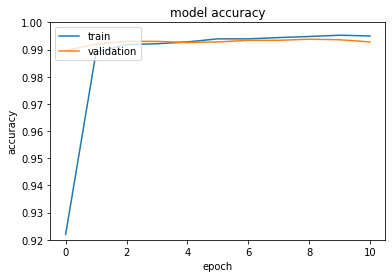

In [ ]:
import matplotlib.pyplot as plt

#Results: summarize the history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(.92,1)
plt.show()


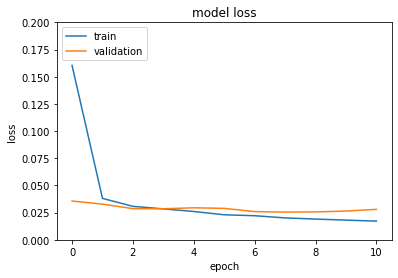

In [ ]:
#Summarize for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Percentage accuracy of model
labels_pred = model.predict(data_ts)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_ts, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 99.18%


In [ ]:
print(classification_report(labels_ts, labels_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2000
           1       1.00      0.99      0.99      3000

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [ ]:
print('\n# Evaluate')
model.evaluate(data_ts, labels_ts)


# Evaluate
157/157 [==============================] - 27s 173ms/step - loss: 0.0331 - acc: 0.9918


[0.03312932699918747, 0.9918000102043152]

In [ ]:
score = model.evaluate(data_ts, labels_ts, verbose=0)


Logistic Regression

In [ ]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [ ]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

In [ ]:
# Training the logistic regression model
from math import log, sqrt, exp
from numpy import sign

LEARNING_RATE = 0.5

logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_tr[0]))
bias_logreg, weights_logreg = logreg.train(data_tr, labels_tr)
y_logistic = [round(logreg.predict(example)) for example in data_ts]

In [ ]:
# Getting (and comparing) the accuracy of the logistic regression model predicting the test data
accuracy_logistic = get_accuracy(y_logistic, labels_ts)
print('Benchmark Model Accuracy: {:0.3f}'.format(accuracy_logistic))

print("Original Model Accuracy: %.2f%%" % (accuracy*100))

Benchmark Model Accuracy: 60.460
Original Model Accuracy: 99.18%
